# Experimenting with random forest and XGBoost regressor models

In [391]:
from pathlib import Path
import warnings
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

import xgboost as xgb

In [193]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [5]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [507]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# Split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

# Add column of pure random noise which will be used for comparison in feature importance analysis later
# Random values between 0 and 1
df['noise'] = np.random.rand(df.shape[0])

# Back fill the 6_550 missing values in day-ahead price feature; random forest regressor doesn't handle NaNs!
df['day_ahead_price_eur_mwh'].fillna(method='bfill', inplace=True)

# Drop total_nominal_capacity_smard_mw as it has yearly temporal resolution and my version has quasi-daily
df.drop(columns=['total_nominal_capacity_smard_mw'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   hour                                            48168 non-null  int32   
 1   day_of_week                                     48168 non-null  int32   
 2   day_of_month                                    48168 non-null  int32   
 3   day_of_year                                     48168 non-null  int32   
 4   week_of_year                                    48168 non-null  int32   
 5   month_number                                    48168 non-null  int32   
 6   year                                            48168 non-null  int32   
 7   meteorological_season                           48168 non-null  category
 8   public_holiday                                  48168 non-n

In [508]:
# # set columns with object dtypes to categorical dtypes (needed for xgboost)
# columns_object_dtype = df.select_dtypes('object').columns.to_list()
# df[columns_object_dtype] = df[columns_object_dtype].astype('category')

# # cast day of week UInt32 to int32
# df['week_of_year'] = df['week_of_year'].astype('int32')

# # Save latest to pickle
# df.to_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

In [509]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

In [510]:
df.isna().sum()

hour                                              0
day_of_week                                       0
day_of_month                                      0
day_of_year                                       0
week_of_year                                      0
month_number                                      0
year                                              0
meteorological_season                             0
public_holiday                                    0
turbines_in_operation                             0
total_nominal_capacity_operational_turbines_mw    0
total_nominal_capacity_smard_mw                   0
day_ahead_price_eur_mwh                           0
total_net_load_smard_mwh                          0
residual_load_smard_mwh                           0
temp_2m_celsius                                   0
mean_sea_level_pressure_mb                        0
wind_gusts_10m                                    0
mean_wind_speed_10m                               0
mean_wind_sp

-----

## Random forest baseline using unweighted ERA5 features
- RandomForestRegressor does not accept missing values encoded as NaN, so I must impute these in `day_ahead_price_eur_mwh`
    - Since the first 6_550 values in `day_ahead_price_eur_mwh` are missing (c. 14% of timestamp instances), just drop column for now
    - Update: I back-filled these missing values because I think keeping the feature is more important
- Sklearn regression metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring

In [237]:
# # Split using c. 80% of timestamps for train set and the rest for test
# train_length = int(round(len(df) * 0.8, -3))
# test_length = len(df) - train_length

# # Train sets for X & y
# X_train = df_unweighted.iloc[:train_length].drop(columns=['actual_generated_smard_mwh']).copy()
# y_train = df_unweighted.iloc[:train_length]['actual_generated_smard_mwh'].copy()

# # Test sets for X & y
# X_test = df_unweighted.iloc[-test_length:].drop(columns=['actual_generated_smard_mwh']).copy()
# y_test = df_unweighted.iloc[-test_length:]['actual_generated_smard_mwh'].copy()

#### Assign my X & y

In [511]:
# drop target and day ahead price because of # of missing values
X = df_unweighted.drop(columns=['actual_generated_smard_mwh', 'day_ahead_price_eur_mwh']).copy()
y = df_unweighted['actual_generated_smard_mwh'].copy()

#### Instantiate time series split object used for cross validation

In [413]:
tscv = TimeSeriesSplit(
    n_splits=5,
)

#### Create ordinal encoder for categorical features

In [414]:
df_unweighted.select_dtypes('category').columns.to_list()

['meteorological_season',
 'wind_direction_intercardinal_10m',
 'wind_direction_intercardinal_100m']

In [432]:
# List my categorical features
categorical_features = [
    'meteorological_season',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# the unique values for each categorical feature; must be in order of list above
categories = [
    # meteorological_season
    ['winter', 'spring', 'summer', 'autumn'],
    # wind_direction_intercardinal_10m
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    # wind_direction_intercardinal_100m
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
]

# Instantiate ordinal encoder and provide unique categories (could also use defaul of auto)
ordinal_encoder = OrdinalEncoder(categories=categories)

#### Make a pipeline object using the column transformer and model objects

In [433]:
# Create pipeline object with named steps
rf_pipeline = Pipeline([
    # Step 1: run categorical features through ordinal encoder
    ('transformer',
        ColumnTransformer(
        transformers=[
            ('categorical', ordinal_encoder, categorical_features),
        ],
        remainder='passthrough',
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    )),
    # Step 2: instantiate random forest regressor
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=8,
    )),
]).set_output(transform='pandas')

In [434]:
# test column transformer step and make sure output looks right
# rf_pipeline['transformer'].fit_transform(X)

#### Function to cross validate random forest model using time series split

In [435]:
def cross_validate_pipeline(pipeline, X, y, cv):
    # Evaluate metrics by cv and record fit/score times
    cv_results = cross_validate(
        pipeline,
        X,
        y,
        cv=cv,
        # list of scorers as list of strings (see sklearn documentation for string names)
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        # 15s using all processors (-1) vs default 1 taking 26s
        # n_jobs=-1,
        return_train_score=True,
        return_estimator=True,
        verbose=3,
    )
    # Get cv scores of test/validation splits
    mae = -cv_results['test_neg_mean_absolute_error']
    rmse = -cv_results['test_neg_root_mean_squared_error']
    
    print(
        f'Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n'
        f'Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}'
    )
    
    return cv_results

In [436]:
# Evaluate the pipeline
cv_results = cross_validate_pipeline(rf_pipeline, X, y, cv=tscv)

[CV] END  neg_mean_absolute_error: (train=-967.972, test=-1286.811) neg_root_mean_squared_error: (train=-1274.030, test=-1731.961) total time=   8.6s
[CV] END  neg_mean_absolute_error: (train=-1047.017, test=-1432.192) neg_root_mean_squared_error: (train=-1393.873, test=-1939.188) total time=  17.7s
[CV] END  neg_mean_absolute_error: (train=-1117.867, test=-1462.872) neg_root_mean_squared_error: (train=-1491.302, test=-2038.748) total time=  26.9s
Mean Absolute Error (MAE):     1393.958 +/- 76.793
Root Mean Squared Error (RMSE): 1903.299 +/- 127.790


### Ideas:
- Check which fold/split has the lowest RMSE score 
- Get index of that fold/split
- Use index to get corresponding estimator (in this case my pipeline)
- Access model object in pipeline using its step name
- Get feature importances, plot, etc

#### Get feature importances and plot

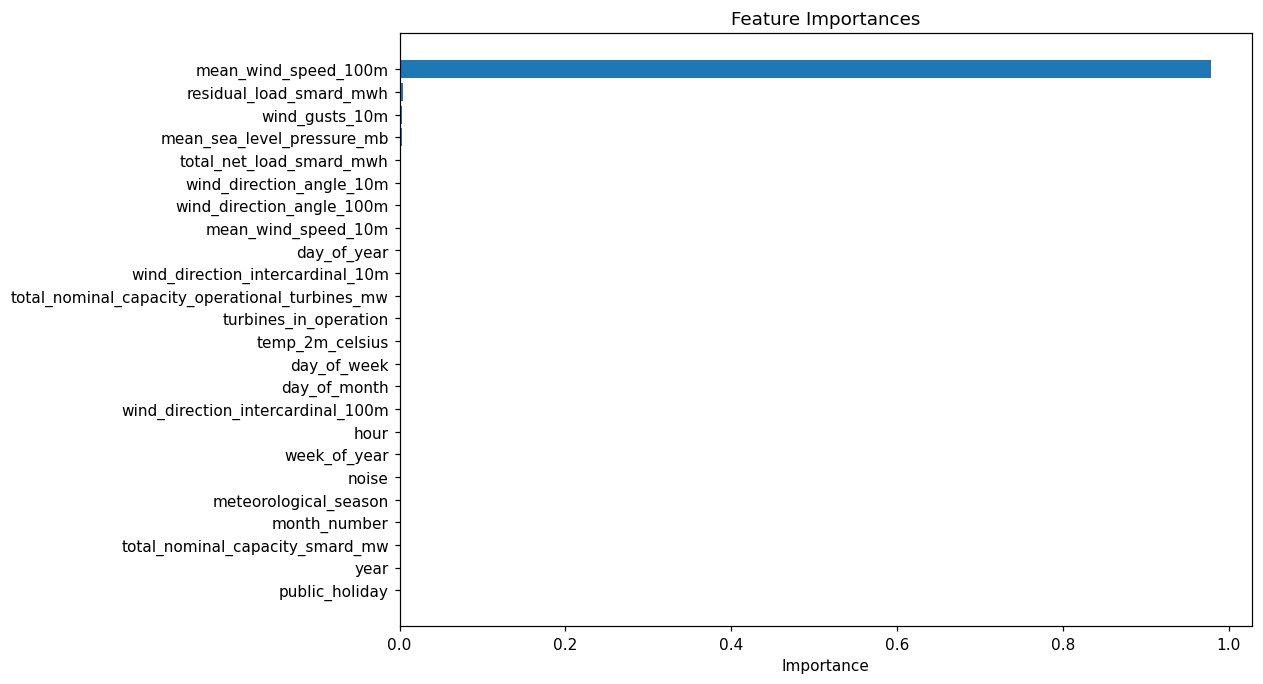

In [503]:
# get index of lowest score in RMSE scores array
idx_best_score = np.absolute(cv_results['test_neg_root_mean_squared_error']).argmin()
# use index to get best model out of pipeline
best_model = cv_results['estimator'][idx_best_score]['model']
# Get model's feature names in
feature_names = best_model.feature_names_in_
# Get model's feature importances
feature_importances = best_model.feature_importances_
# Get sorted indices of feature importances
feature_importances_sorted_indices = feature_importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 7))
plt.title("Feature Importances")
plt.barh(range(len(feature_importances_sorted_indices)), feature_importances[feature_importances_sorted_indices], align='center')
plt.yticks(range(len(feature_importances_sorted_indices)), [feature_names[i] for i in feature_importances_sorted_indices])
plt.xlabel('Importance')
plt.show()

In [506]:
pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

mean_wind_speed_100m                              9.789546e-01
residual_load_smard_mwh                           4.327896e-03
wind_gusts_10m                                    2.687389e-03
mean_sea_level_pressure_mb                        2.626625e-03
total_net_load_smard_mwh                          2.205604e-03
wind_direction_angle_10m                          1.074120e-03
wind_direction_angle_100m                         1.054185e-03
mean_wind_speed_10m                               9.139658e-04
day_of_year                                       8.183301e-04
wind_direction_intercardinal_10m                  7.853219e-04
total_nominal_capacity_operational_turbines_mw    7.671945e-04
turbines_in_operation                             7.011800e-04
temp_2m_celsius                                   6.866496e-04
day_of_week                                       5.749702e-04
day_of_month                                      4.382382e-04
wind_direction_intercardinal_100m                 3.905

### Calculate permutation importance using best estimator
- Shouldn't I use the final fold/split since this uses the largest training set?

In [438]:
# Run X through ordinal encoding
X_transformed = rf_pipeline['transformer'].fit_transform(X)

In [552]:
# Calculate permutation importances on the already-fitted model
permutation_result = permutation_importance(
    best_model, 
    X_transformed, 
    y,
    scoring='neg_root_mean_squared_error',
    n_repeats=5, 
    random_state=0
)


# Create pandas df of mean permutation importances and their standard deviations
df_rf_permutation_importances = pd.DataFrame(data={
    'importances_mean': permutation_result.importances_mean,
    'importances_std': permutation_result.importances_std
}, index=feature_names)

# Sort dataframe for plotting
df_rf_permutation_importances.sort_values(by='importances_mean', ascending=False, inplace=True)
# Round values to better display as bar labels in plot
df_rf_permutation_importances_rounded = df_rf_permutation_importances.applymap(lambda x: round(x, 2))

#### Plot the permutation importances as a horizontal bar plot
- Notes to self:
    - Values for each feature are shuffled/permutated and impact on RMSE is measured
    - Features with high mean accuracy decrease have high predictive power (large RMSE (i.e. error) increase when shuffled)

In [553]:
df_rf_permutation_importances_rounded

,importances_mean,importances_std
mean_wind_speed_100m,9517.28,15.46
residual_load_smard_mwh,458.49,5.52
total_net_load_smard_mwh,197.92,3.50
wind_gusts_10m,103.74,1.80
mean_sea_level_pressure_mb,48.77,1.81
mean_wind_speed_10m,25.37,0.57
wind_direction_intercardinal_10m,13.65,0.19
temp_2m_celsius,12.77,0.33
wind_direction_angle_10m,11.18,0.47
wind_direction_angle_100m,10.57,0.43


In [442]:
rf_permutation_importances

meteorological_season                                0.975983
wind_direction_intercardinal_10m                    13.639056
wind_direction_intercardinal_100m                    5.547852
hour                                                 4.867370
day_of_week                                          3.880016
day_of_month                                         3.305691
day_of_year                                          4.364085
week_of_year                                         1.941757
month_number                                         0.291085
year                                                 0.079412
public_holiday                                       0.000101
turbines_in_operation                                4.369093
total_nominal_capacity_operational_turbines_mw       3.082192
total_nominal_capacity_smard_mw                      0.202400
total_net_load_smard_mwh                           195.578076
residual_load_smard_mwh                            462.605189
temp_2m_

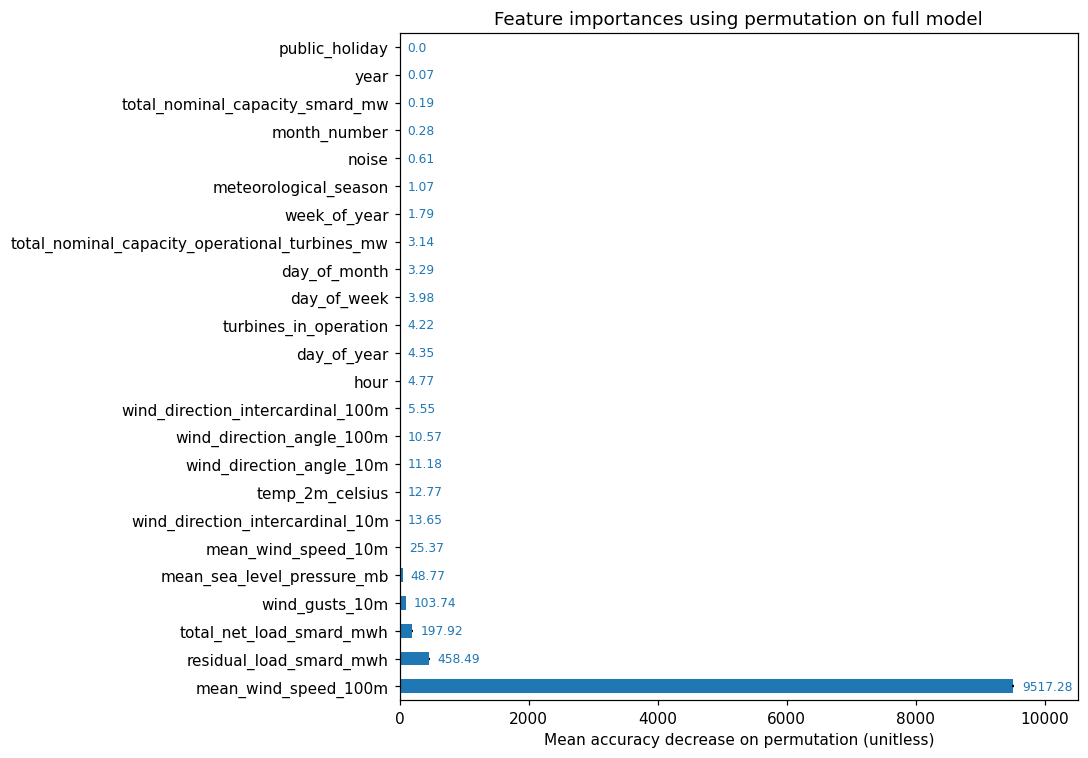

In [554]:
fig, ax = plt.subplots(figsize=(10, 7))
df_rf_permutation_importances_rounded['importances_mean'].plot.barh(xerr=df_rf_permutation_importances_rounded['importances_std'], ax=ax)
ax.set_title('Feature importances using permutation on full model')
ax.set_xlabel('Mean accuracy decrease on permutation (unitless)')

ax.bar_label(
    ax.containers[1],
    labels=df_rf_permutation_importances_rounded['importances_mean'], 
    padding=5,
    fontsize=8,
    color='tab:blue',
)

ax.set_xlim(right=df_rf_permutation_importances_rounded['importances_mean'].max()+1000)

fig.tight_layout()
plt.show()

In [441]:
rf_permutation_importances

meteorological_season                                0.975983
wind_direction_intercardinal_10m                    13.639056
wind_direction_intercardinal_100m                    5.547852
hour                                                 4.867370
day_of_week                                          3.880016
day_of_month                                         3.305691
day_of_year                                          4.364085
week_of_year                                         1.941757
month_number                                         0.291085
year                                                 0.079412
public_holiday                                       0.000101
turbines_in_operation                                4.369093
total_nominal_capacity_operational_turbines_mw       3.082192
total_nominal_capacity_smard_mw                      0.202400
total_net_load_smard_mwh                           195.578076
residual_load_smard_mwh                            462.605189
temp_2m_

----

# Sklearn tutorial
- Following this guide: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py
- Using a Histogram-based Gradient Boosting Regression Tree
    - "This estimator is much faster than GradientBoostingRegressor for big datasets (n_samples >= 10 000)."
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

### Split into X and y

In [111]:
# reset index before assigning to X and y (not needed though!)
X = df.reset_index(drop=True).drop(columns=['actual_generated_smard_mwh']).copy()
y = df['actual_generated_smard_mwh'].reset_index(drop=True).copy()

### Train-test split

In [89]:
# test_size defaults to n_samples // (n_splits + 1)
ts_cv = TimeSeriesSplit(
    n_splits=5,
)

In [90]:
# list of tuples
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[1]

In [77]:
X.loc[train_0]

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m
0,0,0,1,1,1,1,2018,winter,1,27464,49732.097897,51633.0,NaN,44270.00,11634.25,8.510492,1000.349453,12.419700,5.978772,10.395984,220.756622,225.207733,SW,SW,9.207286,997.749018,13.089894,6.337690,10.819870,223.051711,226.127482,SW,SW
1,1,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,43195.75,9928.75,8.281854,1000.427969,13.007113,6.309438,10.805341,224.697327,228.564713,SW,SW,8.921161,997.737445,13.771541,6.722992,11.314126,226.120270,228.464003,SW,SW
2,2,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42527.50,8371.50,8.135431,1000.821328,13.622252,6.685641,11.288467,228.800705,232.298874,SW,SW,8.717961,998.046871,14.434282,7.154381,11.899254,229.267554,231.341858,SW,SW
3,3,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42515.75,8291.25,7.977838,1001.264219,14.090265,6.894922,11.552816,231.736252,235.041382,SW,SW,8.495501,998.378348,14.913757,7.391741,12.219056,230.808404,232.740422,SW,SW
4,4,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42278.00,7465.50,7.647913,1001.436406,14.186666,7.060956,11.751130,234.274536,236.804169,SW,WSW,8.080761,998.388523,14.866367,7.513337,12.358206,231.433313,233.460190,SW,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44115,3,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,2.61,49506.25,8314.50,8.313379,1006.289844,13.024461,6.449370,10.774096,226.965210,230.212204,SW,SW,8.585022,1003.483023,13.466192,6.813139,11.295319,228.370180,230.850240,SW,SW
44116,4,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,25.26,52638.25,10986.00,8.127496,1006.169141,12.881628,6.409419,10.701361,226.697006,229.853973,SW,SW,8.342410,1003.437344,13.373288,6.804776,11.253043,228.182394,230.529813,SW,SW
44117,5,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,54.74,59019.25,17285.00,7.912073,1006.077891,12.639521,6.380711,10.680335,226.540924,229.737335,SW,SW,8.083901,1003.333545,13.156886,6.718736,11.159155,227.496852,230.026468,SW,SW
44118,6,4,13,13,2,1,2023,winter,0,29256,57976.439837,57590.0,87.88,64815.25,23570.75,7.718988,1006.121406,12.492948,6.357946,10.649693,226.436768,229.608704,SW,SW,7.873860,1003.354516,13.023590,6.736384,11.193872,226.959495,229.530292,SW,SW


In [42]:
X.loc[test_0]

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m
44168,8,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,10.31,51397.75,12202.50,5.406946,1000.247344,11.662423,5.877106,9.781042,234.622757,237.615707,SW,WSW,5.184754,997.958953,12.734269,6.578205,10.817939,232.670574,235.483010,SW,SW
44169,9,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,9.01,54254.50,11382.50,5.204279,1000.590312,12.385633,6.263914,10.252373,234.958084,237.565277,SW,WSW,5.090711,998.184500,13.804772,7.125914,11.494802,231.888001,234.297535,SW,SW
44170,10,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,8.03,56948.25,10013.50,5.156183,1001.186328,13.257323,6.027215,9.743527,237.229889,240.494461,WSW,WSW,5.194657,998.488488,14.829649,6.946623,11.084775,231.609848,234.435706,SW,SW
44171,11,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,6.76,57474.25,8074.00,5.172968,1001.423359,14.176562,6.496962,10.365922,234.870285,237.572205,SW,WSW,5.427681,998.510696,15.818420,7.283194,11.529258,226.710877,229.144509,SW,SW
44172,12,6,15,15,2,1,2023,winter,0,29257,57978.839837,57590.0,0.42,56447.25,6963.75,5.272272,1001.607578,15.138498,7.252471,11.357768,234.997757,236.875290,SW,WSW,5.671714,998.443703,16.850840,8.057449,12.500897,226.365169,227.916477,SW,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45163,19,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,116.64,54312.75,29319.00,0.186182,1011.552187,8.462560,4.414219,7.583502,240.662125,212.408340,WSW,SSW,0.339412,1012.259017,8.705034,4.637765,7.963603,222.554030,198.268195,SW,SSW
45164,20,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,102.27,52111.75,28403.50,-0.147131,1012.242734,8.173893,4.272473,7.425100,217.018707,183.344528,SW,S,-0.005601,1012.911615,8.312863,4.445406,7.739634,204.273171,174.140034,SSW,S
45165,21,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,114.93,51050.00,28754.75,-0.497595,1012.940625,7.773402,4.083232,7.163591,211.271347,167.627945,SSW,SSE,-0.340541,1013.670359,7.859276,4.212494,7.431773,194.231024,150.580569,SSW,SSE
45166,22,5,25,56,8,2,2023,winter,0,29264,58135.614847,57590.0,107.43,48494.50,27549.25,-0.775366,1013.459219,7.375617,3.892795,6.894822,186.092102,127.076477,S,SE,-0.565690,1014.217294,7.430191,4.097715,7.221317,188.676609,127.553264,S,SE


In [78]:
df.select_dtypes('object').columns

Index(['meteorological_season', 'wind_direction_intercardinal_10m',
       'wind_direction_intercardinal_100m',
       'weighted_wind_direction_intercardinal_10m',
       'weighted_wind_direction_intercardinal_100m'],
      dtype='object')

In [79]:
# List my categorical features
categorical_features = [
    'meteorological_season',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# the unique values for each categorical feature
categories = [
    ['winter', 'spring', 'summer', 'autumn'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

In [53]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('categorical', ordinal_encoder, categorical_features),
        ],
        remainder='passthrough',
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=42,
    ),
).set_output(transform='pandas')

In [55]:
# Evaluate the model
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     1132.045 +/- 214.656
Root Mean Squared Error: 1538.156 +/- 285.599


-----

# XGBoost

In [80]:
regr = xgb.XGBRegressor()

In [81]:
regr

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [82]:
df

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,meteorological_season,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,wind_direction_intercardinal_10m,wind_direction_intercardinal_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,weighted_wind_direction_intercardinal_10m,weighted_wind_direction_intercardinal_100m,actual_generated_smard_mwh
datetime_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0,0,1,1,1,1,2018,winter,1,27464,49732.097897,51633.0,NaN,44270.00,11634.25,8.510492,1000.349453,12.419700,5.978772,10.395984,220.756622,225.207733,SW,SW,9.207286,997.749018,13.089894,6.337690,10.819870,223.051711,226.127482,SW,SW,29638.00
2018-01-01 01:00:00+00:00,1,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,43195.75,9928.75,8.281854,1000.427969,13.007113,6.309438,10.805341,224.697327,228.564713,SW,SW,8.921161,997.737445,13.771541,6.722992,11.314126,226.120270,228.464003,SW,SW,30173.75
2018-01-01 02:00:00+00:00,2,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42527.50,8371.50,8.135431,1000.821328,13.622252,6.685641,11.288467,228.800705,232.298874,SW,SW,8.717961,998.046871,14.434282,7.154381,11.899254,229.267554,231.341858,SW,SW,31021.50
2018-01-01 03:00:00+00:00,3,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42515.75,8291.25,7.977838,1001.264219,14.090265,6.894922,11.552816,231.736252,235.041382,SW,SW,8.495501,998.378348,14.913757,7.391741,12.219056,230.808404,232.740422,SW,SW,31015.00
2018-01-01 04:00:00+00:00,4,0,1,1,1,1,2018,winter,0,27464,49732.097897,51633.0,NaN,42278.00,7465.50,7.647913,1001.436406,14.186666,7.060956,11.751130,234.274536,236.804169,SW,WSW,8.080761,998.388523,14.866367,7.513337,12.358206,231.433313,233.460190,SW,SW,31534.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00+00:00,19,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,130.74,48794.25,44133.75,17.934381,1010.896875,3.549851,1.842328,3.449438,277.569061,278.582458,W,W,18.057953,1010.494333,3.268352,1.735454,3.298011,267.207132,272.506988,W,W,1698.75
2023-06-30 20:00:00+00:00,20,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,122.39,46764.00,41337.00,16.834222,1011.285156,3.295196,1.792745,3.391158,265.232117,275.095490,W,W,16.788159,1010.739602,3.169172,1.802858,3.440641,246.381887,261.133282,WSW,W,2334.25
2023-06-30 21:00:00+00:00,21,4,30,181,26,6,2023,summer,0,29412,59315.041337,57590.0,109.47,43702.00,36306.00,16.122461,1011.060078,3.497805,1.922537,3.609585,253.096542,263.328888,WSW,W,16.075749,1010.446129,3.555140,2.041097,3.894662,235.312803,244.281213,SW,WSW,3734.00


-----

## Visualise train-test splits!

#### Train-test split keeping index as datetime

In [512]:
# keep datetime index!
X = df.drop(columns=['actual_generated_smard_mwh']).copy()
y = df['actual_generated_smard_mwh'].copy()

### Plot train-test split

In [513]:
X.index.min()

Timestamp('2018-01-01 00:00:00+0000', tz='UTC')

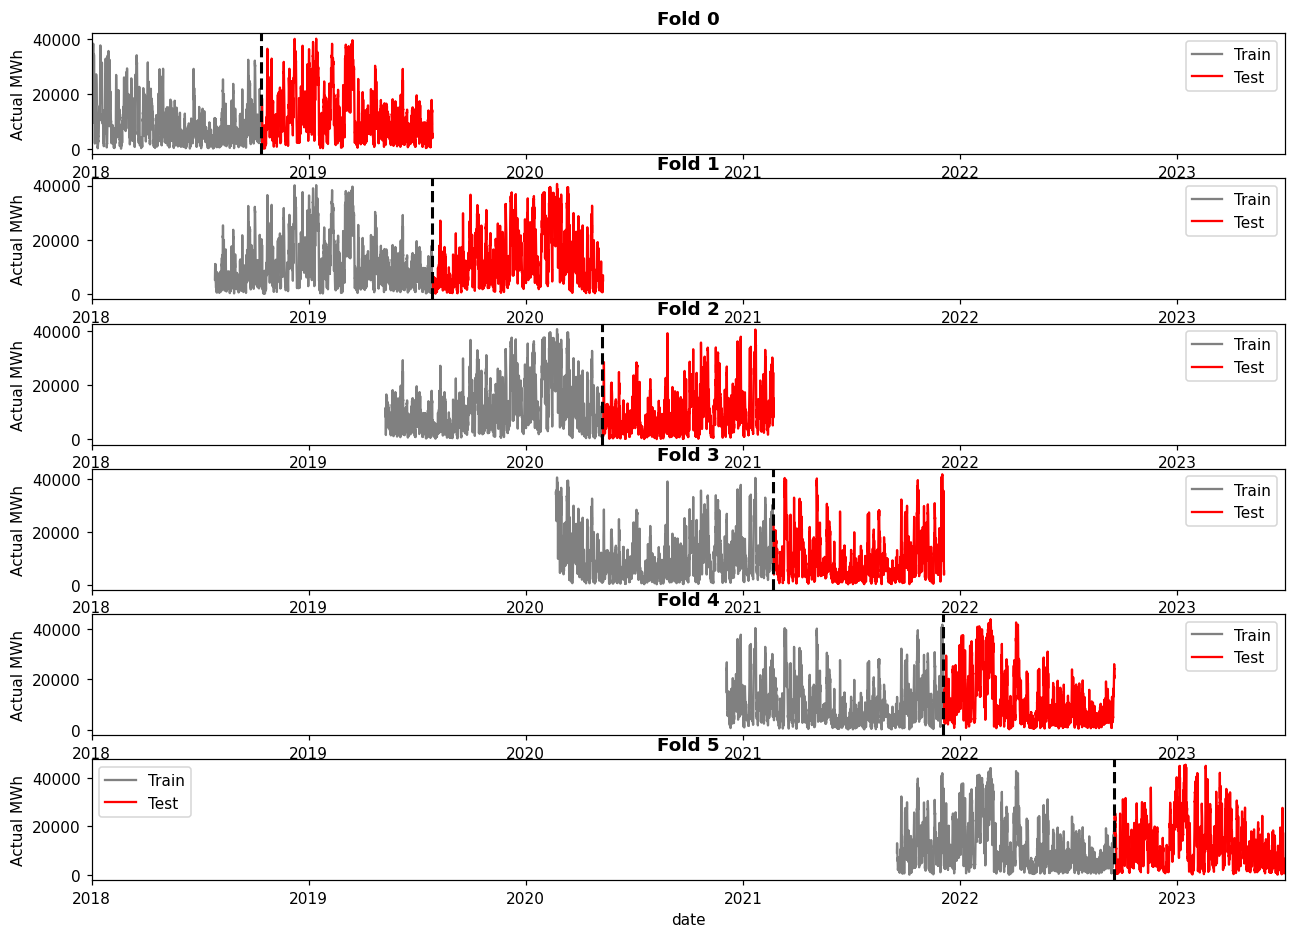

In [559]:
# Instantiate time series split
n_splits = 6
tscv = TimeSeriesSplit(
    n_splits=n_splits,
    gap=24,
    max_train_size=8_760,
    # test_size=1_000,
)

# Plot the splits
fig, axes = plt.subplots(n_splits, figsize=(14, 10))

# Loop through the splits and plot
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    ax = axes[i]
    
    ax.plot(y.index[train_index], y.iloc[train_index], 'grey', label='Train')
    ax.plot(y.index[test_index], y.iloc[test_index], 'red', label='Test')
    
    ax.set_xlim(X.index.min(), X.index.max())
    # plot vertical line denoting where the split takes place
    ax.axvline(
        y.index[train_index][-1], color='black', linestyle='--', linewidth=2, alpha=1
    )
    
    ax.legend()
    ax.set_title(f'Fold {i}', fontweight='bold')
    ax.set_xlabel('date')
    ax.set_ylabel('Actual MWh')

    
# plt.tight_layout()
plt.show()

#### Manually inspect the split dates and lengths

In [524]:
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f'Train index length: {len(train_index)}')
    print(f'Test index length: {len(test_index)}')
    print('-----')
    print(f'Split date: {y.index[train_index][-1]}')

Train index length: 10000
Test index length: 2000
-----
Split date: 2022-10-23 23:00:00+00:00
Train index length: 10000
Test index length: 2000
-----
Split date: 2023-01-15 07:00:00+00:00
Train index length: 10000
Test index length: 2000
-----
Split date: 2023-04-08 15:00:00+00:00


In [28]:
12042 + 24084 + 36126

72252

In [143]:
df['actual_generated_smard_mwh'].describe()

count    48168.000000
mean     11193.426461
std       8992.759097
min        100.250000
25%       4245.875000
50%       8473.000000
75%      15918.500000
max      45285.250000
Name: actual_generated_smard_mwh, dtype: float64

#### Train-split

In [135]:
# test_size defaults to n_samples // (n_splits + 1)
ts_cv = TimeSeriesSplit(
    n_splits=5,
)

In [136]:
# list of tuples
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[1]

In [137]:
all_splits[0][0]

array([   0,    1,    2, ..., 8025, 8026, 8027])

In [1]:
# X.loc[all_splits[1][1]]

------

## Following along with the YouTube tutorial
- https://www.youtube.com/watch?v=vV12dGe_Fho&t=342s

#### Perform a simple split using a single date to create a test and train set

In [544]:
train = df_unweighted.loc[df.index < '2023-01-01']
test = df_unweighted.loc[df.index >= '2023-01-01']

In [545]:
len(train)

43824

In [546]:
len(test)

4344

#### Plot the test and train sets

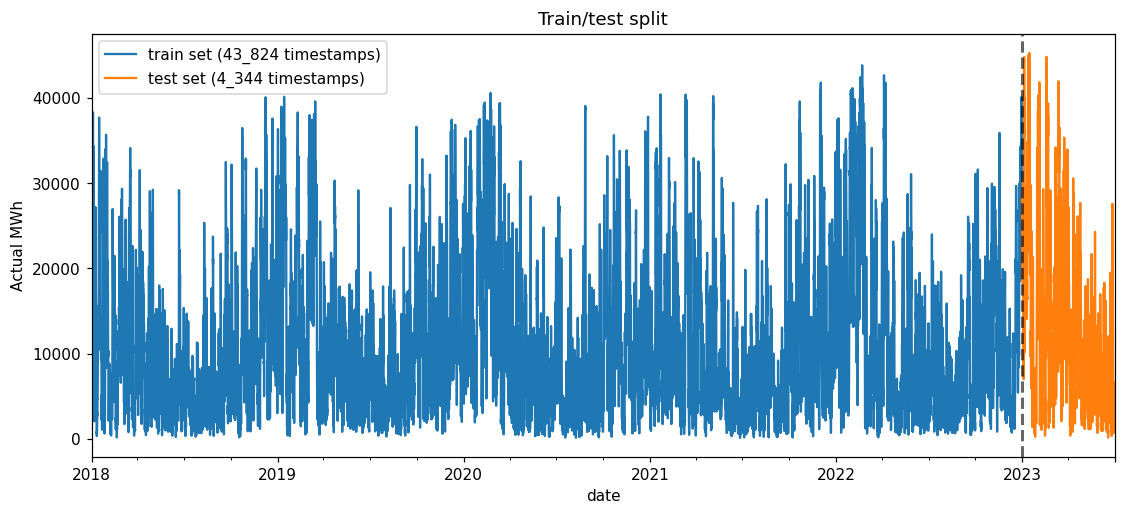

In [549]:
fig, ax = plt.subplots(figsize=(12,5))

train['actual_generated_smard_mwh'].plot(ax=ax, label='training set', title='Train/test split')
test['actual_generated_smard_mwh'].plot(ax=ax, label='test set')

ax.axvline('2023-01-01', color='black', ls='--', linewidth=2, alpha=0.6)
ax.legend(['train set (43_824 timestamps)', 'test set (4_344 timestamps)'])
ax.set_xlabel('date')
ax.set_ylabel('Actual MWh')

plt.show()

#### Assign X and y train and test sets

In [114]:
# train sets
X_train = train.drop(columns=['actual_generated_smard_mwh']).copy()
y_train = train['actual_generated_smard_mwh'].copy()

# test sets
X_test = test.drop(columns=['actual_generated_smard_mwh']).copy()
y_test = test['actual_generated_smard_mwh'].copy()

In [115]:
# Instantiate the model object
regr = xgb.XGBRegressor(
    n_estimators=1_000,
    tree_method='hist',
    # stop if no RMSE improvement in test set (validation_1) after 50 iterations
    # helps to prevent overfitting when train RMSE keeps improving but test RMSE continues to get worse
    early_stopping_rounds=50,
    # experimental?
    enable_categorical=True
)

regr

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### I need to ordinal and one-hot encode some columns!

#### List categorial features and their unique values for encoding

In [98]:
df.select_dtypes('category').columns

Index(['meteorological_season', 'wind_direction_intercardinal_10m',
       'wind_direction_intercardinal_100m',
       'weighted_wind_direction_intercardinal_10m',
       'weighted_wind_direction_intercardinal_100m'],
      dtype='object')

In [99]:
# List my categorical features
categorical_features = [
    'meteorological_season',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# the unique values for each categorical feature
categories = [
    ['winter', 'spring', 'summer', 'autumn'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    
    ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
     'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

#### Make pipeline

In [ ]:
# pipeline = make_pipeline(
#     ColumnTransformer(
#         transformers=[
#             ('categorical', ordinal_encoder, categorical_features),
#         ],
#         remainder='passthrough',
#         # Use short feature names to make it easier to specify the categorical
#         # variables in the HistGradientBoostingRegressor in the next
#         # step of the pipeline.
#         verbose_feature_names_out=False,
#     ),
#     HistGradientBoostingRegressor(
#         categorical_features=categorical_features,
#         random_state=42,
#     ),
# ).set_output(transform='pandas')

#### Fit the model to the data
- `validation_0` is the test set RMSE
- `validation_1` is the train set RMSE

In [116]:
# fit the xgb regressor model
regr.fit(
    X_train, y_train,
    # evaluate RMSE on both train and test sets
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True 
)

[0]	validation_0-rmse:9949.73267	validation_1-rmse:12052.05989
[1]	validation_0-rmse:7044.42460	validation_1-rmse:8894.11919
[2]	validation_0-rmse:5031.10682	validation_1-rmse:6657.95668
[3]	validation_0-rmse:3647.03262	validation_1-rmse:5071.91020


/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

[4]	validation_0-rmse:2711.61687	validation_1-rmse:3999.33061
[5]	validation_0-rmse:2091.83640	validation_1-rmse:3270.40151
[6]	validation_0-rmse:1698.11632	validation_1-rmse:2767.69338
[7]	validation_0-rmse:1450.04005	validation_1-rmse:2442.94807
[8]	validation_0-rmse:1300.63944	validation_1-rmse:2249.14441
[9]	validation_0-rmse:1207.01500	validation_1-rmse:2053.22059
[10]	validation_0-rmse:1150.79659	validation_1-rmse:1944.44050
[11]	validation_0-rmse:1109.98476	validation_1-rmse:1864.51138
[12]	validation_0-rmse:1080.41537	validation_1-rmse:1810.54994
[13]	validation_0-rmse:1057.84795	validation_1-rmse:1767.67880
[14]	validation_0-rmse:1040.70887	validation_1-rmse:1730.68098
[15]	validation_0-rmse:1025.26720	validation_1-rmse:1702.74565
[16]	validation_0-rmse:1010.70411	validation_1-rmse:1694.31487
[17]	validation_0-rmse:995.13042	validation_1-rmse:1678.22949
[18]	validation_0-rmse:985.22988	validation_1-rmse:1647.87802
[19]	validation_0-rmse:972.64774	validation_1-rmse:1638.02383
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [118]:
regr.best_iteration

284

In [121]:
regr.best_score

1470.4106096272171

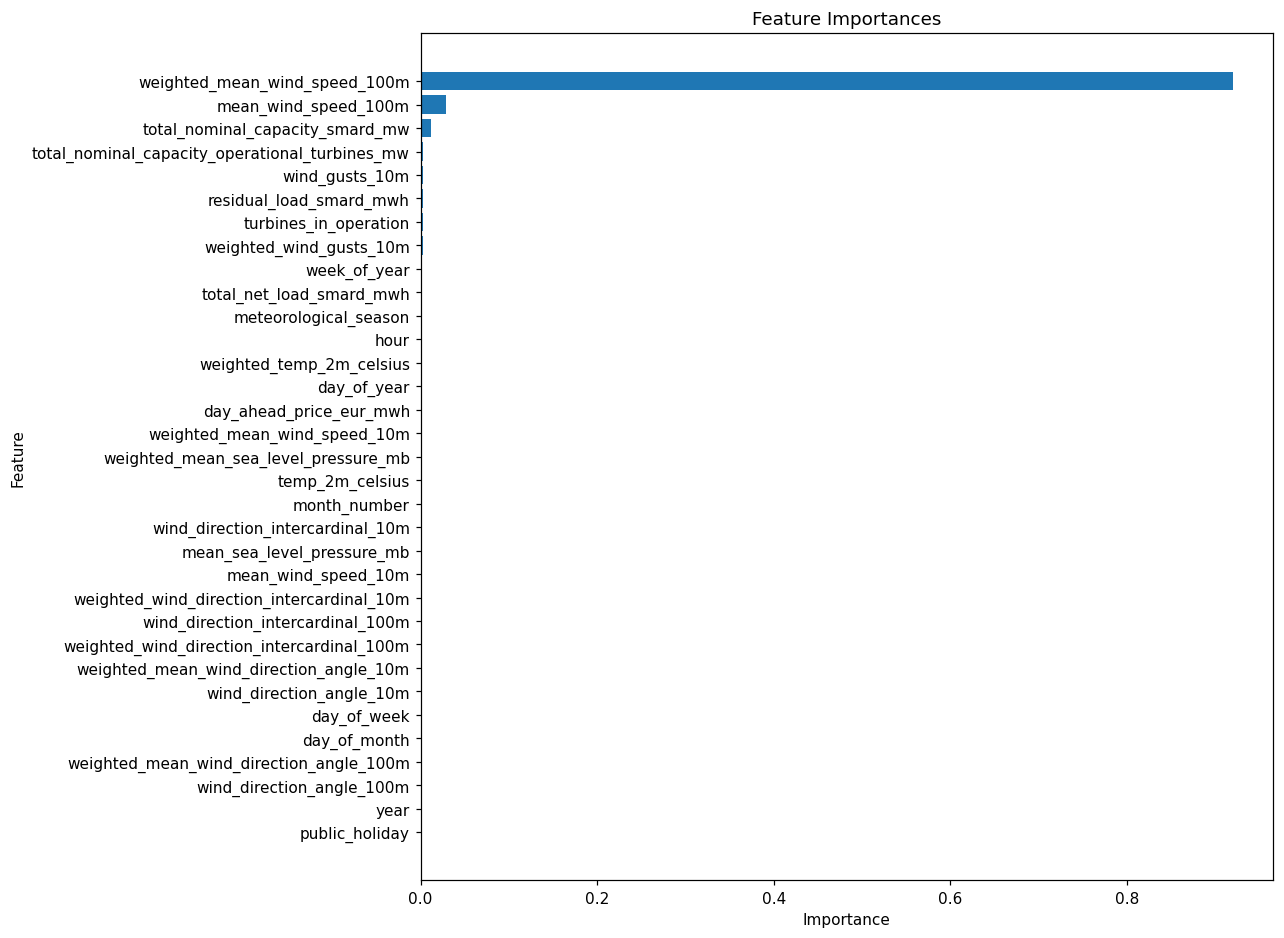

In [142]:
# Get feature importances
feature_importances = regr.feature_importances_
# Get feature importances and get sort indices
feature_importances_sorted_indices = feature_importances.argsort()
# Get feature names in
feature_names = regr.feature_names_in_

# Plot
plt.figure(figsize=(10, 10))
plt.title("Feature Importances")
plt.barh(range(len(feature_importances_sorted_indices)), feature_importances[feature_importances_sorted_indices], align='center')
plt.yticks(range(len(feature_importances_sorted_indices)), [feature_names[i] for i in feature_importances_sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [145]:
regr.importance_type

In [146]:
regr.best_score

1470.4106096272171

-------

------

# Using the unweighted dataframe 

In [198]:
train = df_unweighted.loc[df.index < '2023-01-01'].copy()
test = df_unweighted.loc[df.index >= '2023-01-01'].copy()

# train sets
X_train = train.drop(columns=['actual_generated_smard_mwh'])
y_train = train['actual_generated_smard_mwh']

# test sets
X_test = test.drop(columns=['actual_generated_smard_mwh'])
y_test = test['actual_generated_smard_mwh']

# Instantiate the model object
regr = xgb.XGBRegressor(
    # boosting rounds
    n_estimators=1_000,
    tree_method='hist',
    max_depth=7,
    learning_rate=0.2,
    # stop if no RMSE improvement in test set (validation_1) after 50 iterations
    # helps to prevent overfitting when train RMSE keeps improving but test RMSE continues to get worse
    early_stopping_rounds=50,
    # experimental?
    enable_categorical=True
)

# fit the xgb regressor model
regr.fit(
    X_train, y_train,
    # evaluate RMSE on both train and test sets
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True 
)

[0]	validation_0-rmse:11356.25648	validation_1-rmse:13519.69139
[1]	validation_0-rmse:9151.79362	validation_1-rmse:11071.29860
[2]	validation_0-rmse:7396.93440	validation_1-rmse:9108.87383
[3]	validation_0-rmse:6002.60434	validation_1-rmse:7566.46176
[4]	validation_0-rmse:4898.45342	validation_1-rmse:6354.77221
[5]	validation_0-rmse:4029.99703	validation_1-rmse:5372.05498
[6]	validation_0-rmse:3346.71332	validation_1-rmse:4601.85414
[7]	validation_0-rmse:2817.68178	validation_1-rmse:4017.30299
[8]	validation_0-rmse:2407.33097	validation_1-rmse:3545.35695
[9]	validation_0-rmse:2094.57883	validation_1-rmse:3191.52976
[10]	validation_0-rmse:1857.99943	validation_1-rmse:2910.97989
[11]	validation_0-rmse:1678.71138	validation_1-rmse:2705.92943
[12]	validation_0-rmse:1543.60406	validation_1-rmse:2562.41113
[13]	validation_0-rmse:1440.46369	validation_1-rmse:2428.72492
[14]	validation_0-rmse:1364.81508	validation_1-rmse:2337.77717
[15]	validation_0-rmse:1304.55088	validation_1-rmse:2266.43440

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [199]:
print(regr.best_iteration)
print(regr.best_score)

201
1711.2166409172792


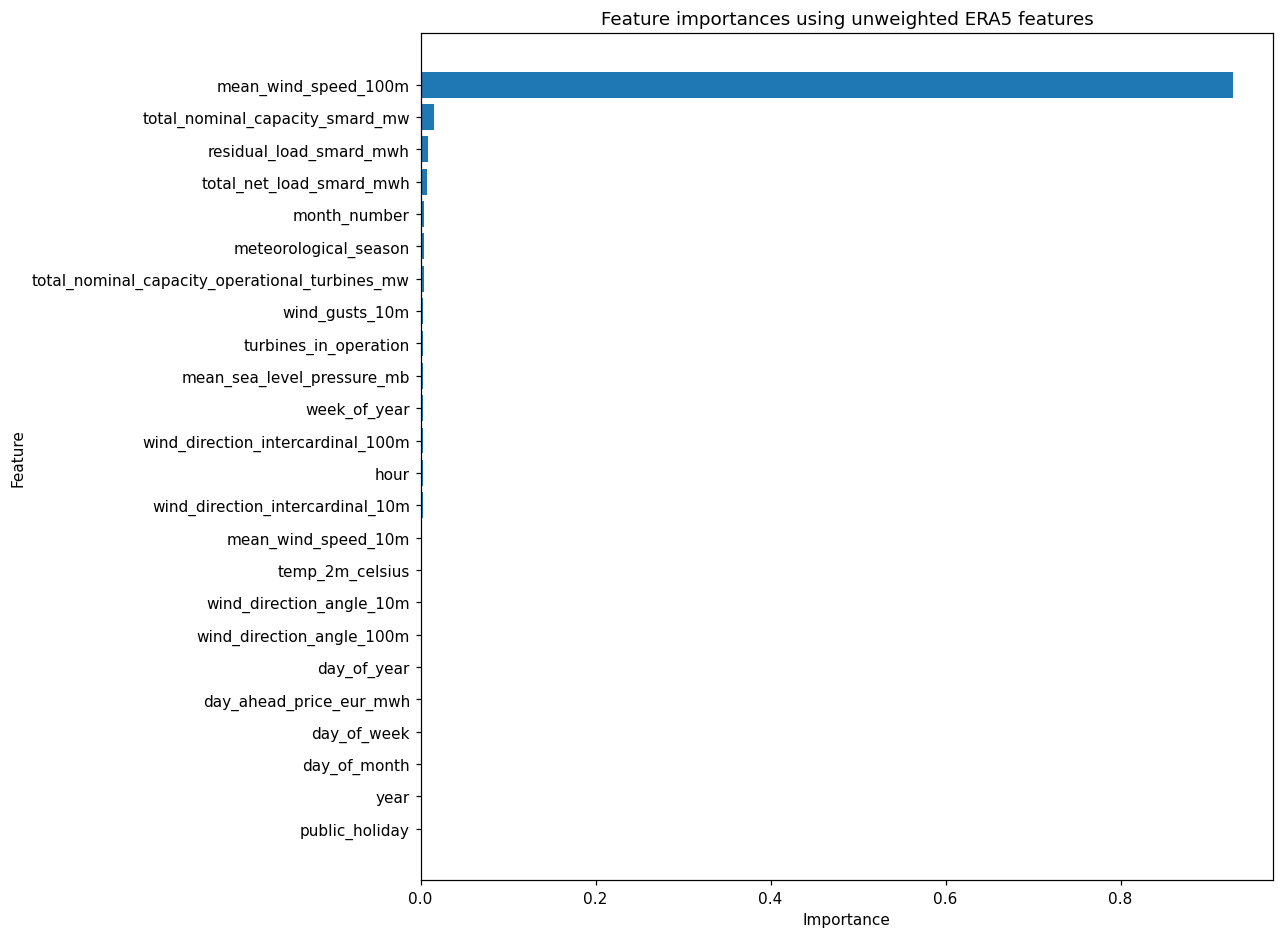

In [200]:
# Get feature importances
feature_importances = regr.feature_importances_
# Get feature importances and get sort indices
feature_importances_sorted_indices = feature_importances.argsort()
# Get feature names in
feature_names = regr.feature_names_in_

# Plot
plt.figure(figsize=(10, 10))
plt.title('Feature importances using unweighted ERA5 features')
plt.barh(range(len(feature_importances_sorted_indices)), feature_importances[feature_importances_sorted_indices], align='center')
plt.yticks(range(len(feature_importances_sorted_indices)), [feature_names[i] for i in feature_importances_sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [201]:
regr.predict(X_test)

array([28516.568 , 28047.209 , 27626.818 , ...,  3755.5613,  5415.629 ,
        6720.4004], dtype=float32)

-----

## XGBoost regressor with TimeSeriesSplit
- Validate the model using time split folds

In [195]:
def train_and_evaluate_model(df, n_splits=5):
    # Assign X & y using df; keep datetime as index and select indexes using .iloc
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Initialise TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    rmse_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Instantiate the model object
        regr = xgb.XGBRegressor(
            n_estimators=1_000,
            tree_method='hist',
            max_depth=7,
            learning_rate=0.2,
            # early_stopping_rounds=50,
            enable_categorical=True
        )
        
        # Fit the model
        regr.fit(
            X_train, y_train,
            # evaluate RMSE on both train and test sets
            # eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=True 
        )
        
        # Predict on test fold
        y_preds = regr.predict(X_test)
        
        # Append RMSE of fold to list
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        rmse_scores.append(rmse)
        
    # mean_rmse = np.mean(rmse_scores)
    
    return rmse_scores

In [196]:
scores = train_and_evaluate_model(df_unweighted, n_splits=3)

In [197]:
# RMSE scores for each time split fold
scores

[1499.994248183147, 1650.3989083894164, 1571.4019755129061]

### Plotting the predictions against the actuals

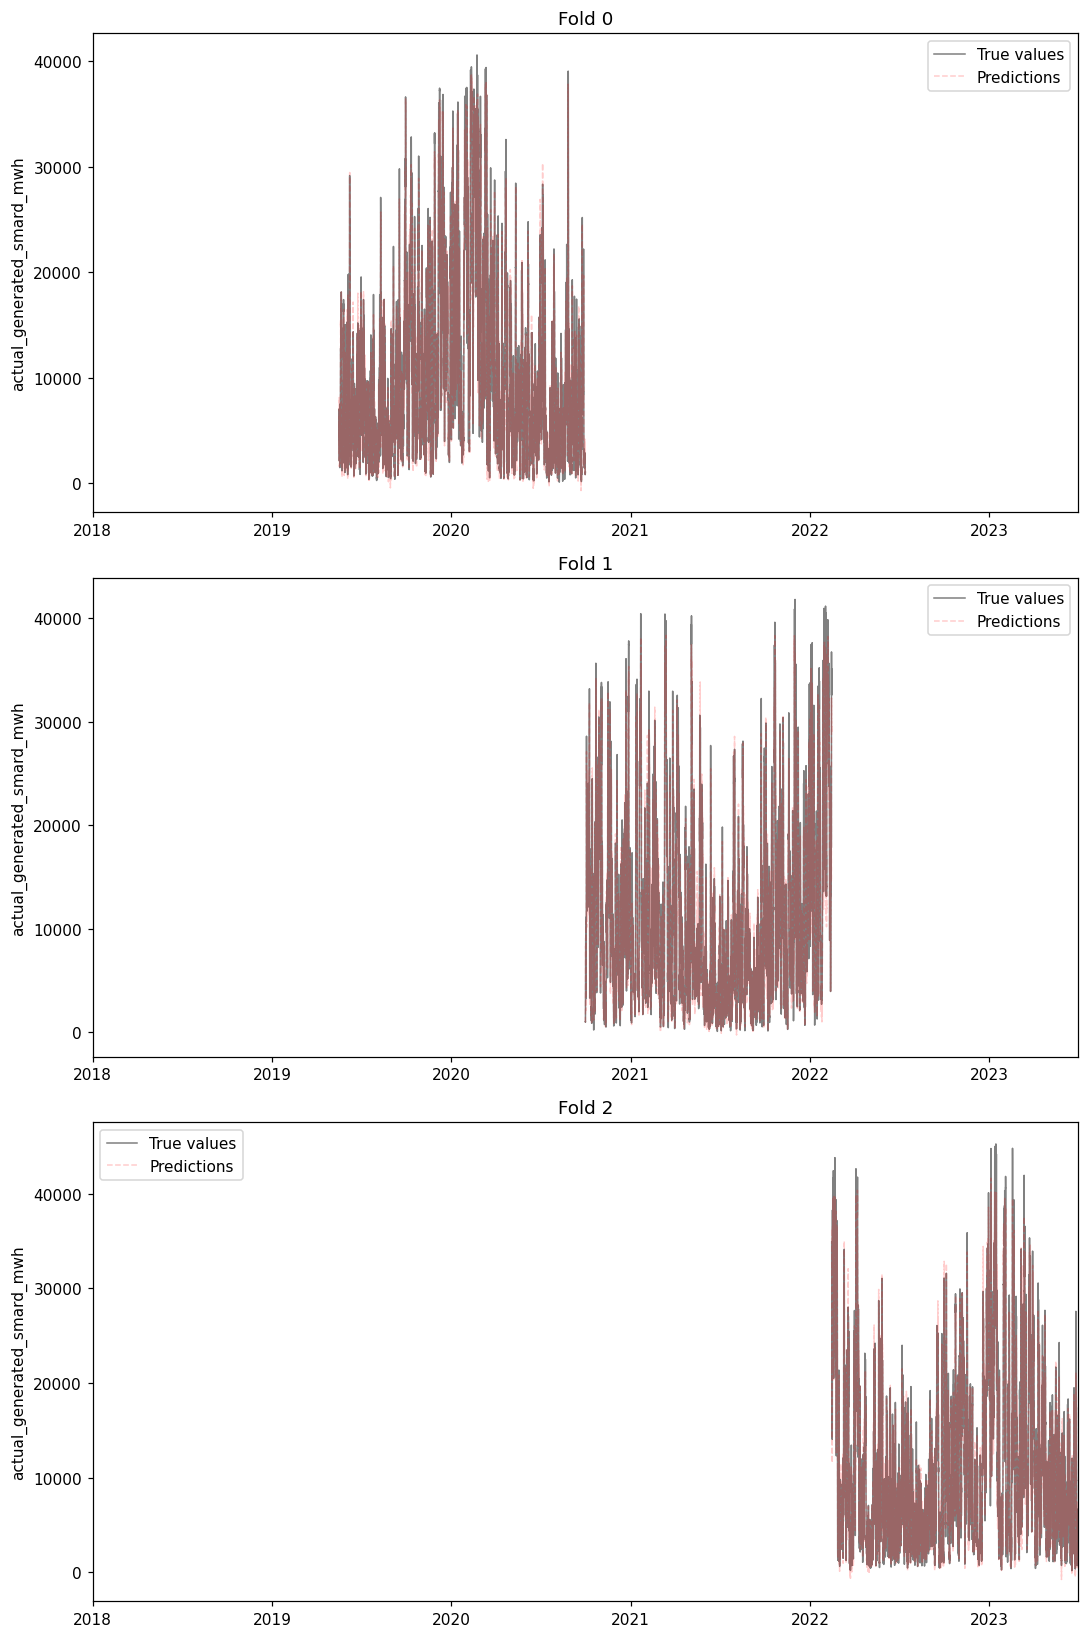

In [194]:
# Assign X & y using df; keep datetime as index and select indexes using .iloc
X = df_unweighted.drop(columns=['actual_generated_smard_mwh']).copy()
y = df_unweighted['actual_generated_smard_mwh'].copy()

# Initialise TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

fig, axs = plt.subplots(nrows=tscv.n_splits, figsize=(10, 15))

for idx, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate the model object
    regr = xgb.XGBRegressor(
        n_estimators=1_000,
        tree_method='hist',
        max_depth=7,
        learning_rate=0.2,
        # early_stopping_rounds=50,
        enable_categorical=True
    )

    # Fit the model
    regr.fit(
        X_train, y_train,
        # evaluate RMSE on both train and test sets
        # eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True 
    )

    # Predict on test fold
    y_preds = regr.predict(X_test)

    # Plot actuals and predictions for this fold
    axs[idx].plot(y.index[test_index], y_test, label='True values', color='grey', linestyle='-', linewidth=1)
    axs[idx].plot(y.index[test_index], y_preds, label='Predictions', color='red', linestyle='dashed', linewidth=1, alpha=0.2)
    
    axs[idx].set_xlim(X.index.min(), X.index.max())
    axs[idx].set_title(f'Fold {idx}')
    axs[idx].set_ylabel('actual_generated_smard_mwh')
    axs[idx].legend()

plt.tight_layout()
plt.show()